### Test on real pic

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2

In [3]:
#load model
model = load_model('./model/ferplus_cnn')

In [4]:
emotion_labels = ["neutral", "happiness", "surprise", "sadness", "anger", "disgust", "fear", "contempt"]

img = cv2.imread("istockphoto-1165314750-612x612.jpg")
print(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minSize=(30, 30)
) 
print(len(faces))
face_imgs = []
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    face_imgs.append(img[y:y+h, x:x+w])
resize_imgs = []
for face in face_imgs:
    resized_face = cv2.resize(face, (48, 48))
    print(resized_face.shape)
    resize_imgs.append(resized_face)
    
resize_imgs = np.array(resize_imgs)
results = model.predict(resize_imgs)
for i, result in enumerate(results):
    print(f"Face #{i}")
    for j, emotion in enumerate(result):
        print(f"{emotion_labels[j]} : {emotion:.4f}")
cv2.imshow('img', img)
cv2.waitKey()

(385, 612, 3)
(385, 612)
1
(48, 48, 3)
Face #0
neutral : 0.0126
happiness : 0.9847
surprise : 0.0001
sadness : 0.0000
anger : 0.0000
disgust : 0.0001
fear : 0.0000
contempt : 0.0025


-1

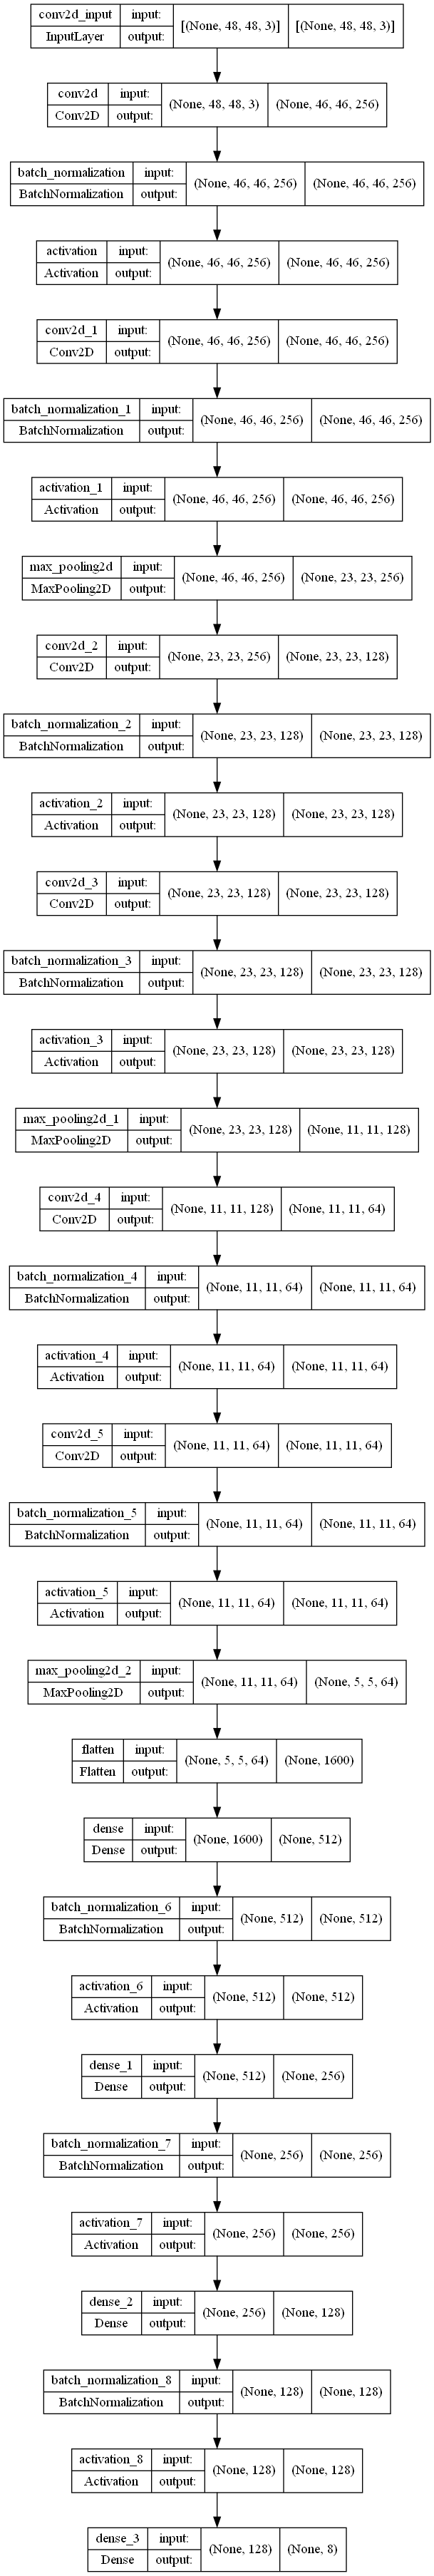

In [9]:
plot_model(model, to_file='model_plot_1.png', show_shapes=True, show_layer_names=True)

In [6]:
data = pd.read_csv("ferplus_filtered.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [7]:
def gen_set(usage="train"):
    df = data[data["Usage"] == usage]
    path = "fer2013/"
    if usage == "train":
        path += 'train/'
    elif usage == "validation" or usage == "test":
        path += 'test/'
    data_X = np.array([cv2.imread(path+x) for x in df["Image name"]])
    data_Y = df[["neutral", "happiness", "surprise", "sadness", "anger", "disgust", "fear", "contempt"]]
    return data_X, data_Y

train_data_X, train_data_Y = gen_set(usage="train")
val_data_X, val_data_Y = gen_set(usage="validation")
test_data_X, test_data_Y = gen_set(usage="test")
print(f"train data X shape = {train_data_X.shape}, train data Y shape = {train_data_Y.shape}")
print(f"val_data_X shape = {val_data_X.shape}, val_data_Y shape = {val_data_Y.shape}")
print(f"test_data_X shape = {test_data_X.shape}, test_data_Y shape = {test_data_Y.shape}")

train data X shape = (28389, 48, 48, 3), train data Y shape = (28389, 8)
val_data_X shape = (3553, 48, 48, 3), val_data_Y shape = (3553, 8)
test_data_X shape = (3546, 48, 48, 3), test_data_Y shape = (3546, 8)


In [8]:
predict_Y = model.predict(test_data_X)
print(predict_Y.shape)

(3546, 8)


In [9]:
emotion_labels = ["neutral", "happiness", "surprise", "sadness", "anger", "disgust", "fear", "contempt"]

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

(3546, 8)


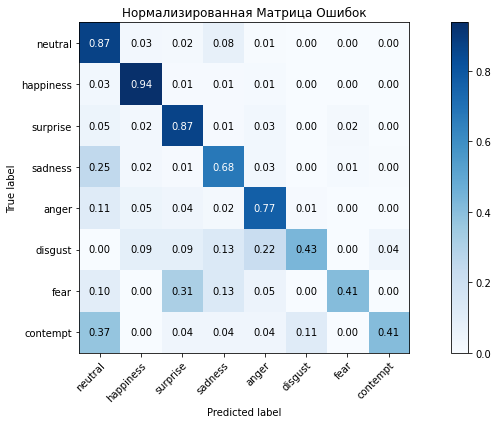

In [18]:
print(test_data_Y.shape)
test_true = np.argmax(test_data_Y.to_numpy(), axis=1)
test_pred = np.argmax(predict_Y, axis=1)
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Нормализированная Матрица Ошибок')
plt.show()